# Data Analysis Interview Challenge

## Part 1 ‐ Exploratory data analysis
##### The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [6]:
import json
import pandas as pd

In [2]:
with open('logins.json') as login_file:
    data = json.load(login_file)

In [7]:
login_data=pd.DataFrame.from_dict(data)

In [33]:
login_data.head()

,login_time,count
login_time,,
1970-01-01 20:13:18,1970-01-01 20:13:18,1
1970-01-01 20:16:10,1970-01-01 20:16:10,1
1970-01-01 20:16:37,1970-01-01 20:16:37,1
1970-01-01 20:16:36,1970-01-01 20:16:36,1
1970-01-01 20:26:21,1970-01-01 20:26:21,1


In [11]:
type(login_data.login_time[0])

str

In [9]:
from datetime import datetime
import numpy as np

In [12]:
login_data['login_time']=pd.to_datetime(login_data['login_time'])

In [14]:
type(login_data.login_time[0])

pandas._libs.tslibs.timestamps.Timestamp

In [25]:
login_data.index=login_data.login_time
login_data['count']=1

In [29]:
resampled_data=login_data.resample('15T').sum()

In [35]:
resampled_data.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


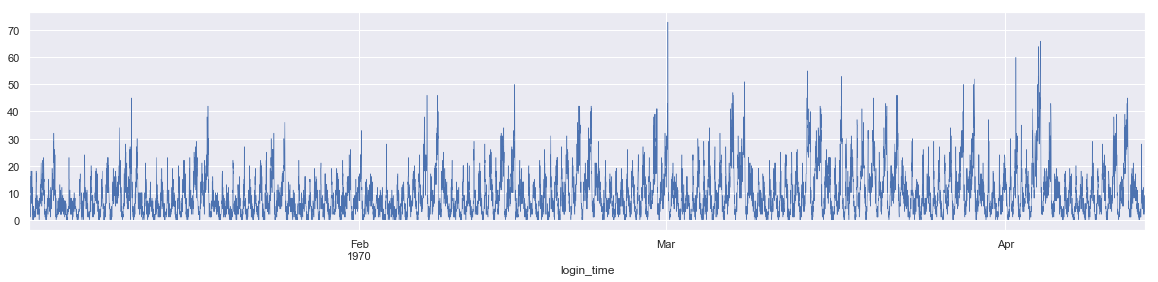

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(20, 4)})
resampled_data['count'].plot(linewidth=0.5)
plt.show()

In [102]:
resampled_by_day=login_data.resample('D').sum()
logins_biz_day = login_data.resample('B').sum()
fridays = login_data.resample('W-FRI').sum()
saturdays = login_data.resample('W-SAT').sum()
sundays = login_data.resample('W-SUN').sum()

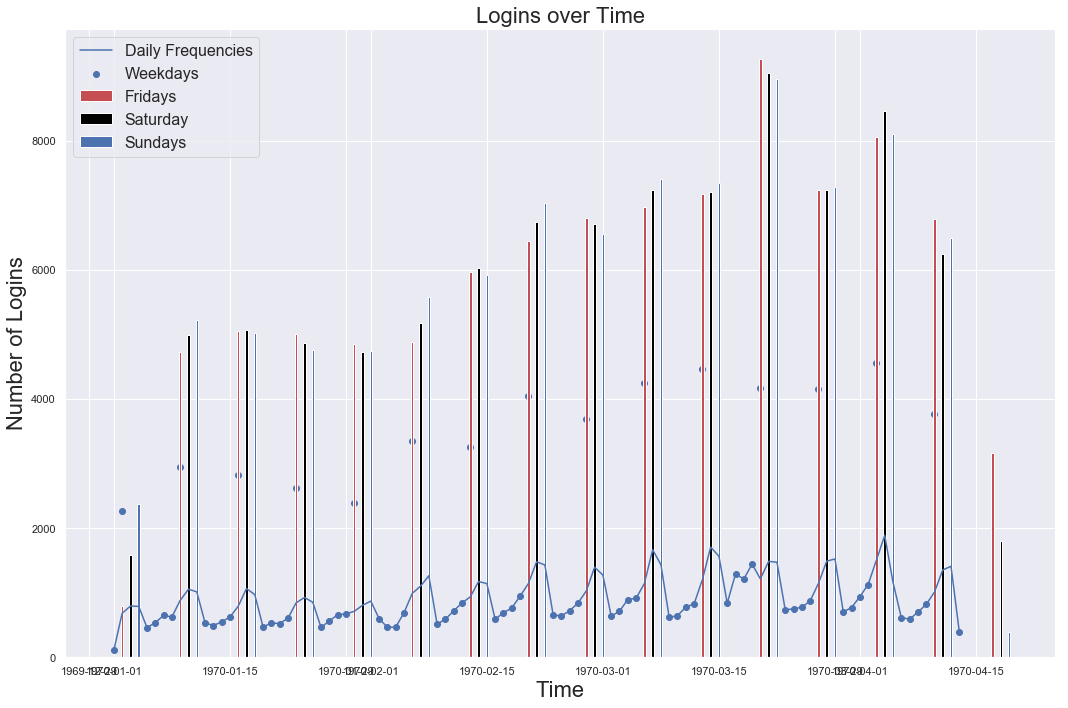

In [119]:
# line, scatterplot, and histograms of the binned data
fig, ax = plt.subplots(figsize = (15,10))
plt.xlabel('Time', fontsize = 22)
plt.ylabel('Number of Logins', fontsize = 22)
plt.title('Logins over Time', fontsize = 22)

ax.bar(fridays.index, fridays['count'], align= 'center', width = 0.3, label = "Fridays", color = 'R')
ax.bar(saturdays.index, saturdays['count'], label = 'Saturday', align = 'center', width = 0.3, color = 'Black')
ax.bar(sundays.index, sundays['count'], label = "Sundays", align= 'center', width = 0.3, color = 'B')
ax.plot(resampled_by_day.index, resampled_by_day['count'], label = 'Daily Frequencies')
ax.scatter(logins_biz_day.index, logins_biz_day['count'], label='Weekdays')

plt.legend(loc='upper left', fontsize = 16)
plt.tight_layout()


In [120]:
# resample index hourly
daily_logins = login_data.resample('H').sum()
# make a column that identify the day of week; Monday=0, Sunday=6
day_of_week = list(daily_logins.index.dayofweek)
daily_logins['day_of_week'] = day_of_week
# add column with just the hour (omiting the date)
daily_logins['hour'] = [time.hour for time in daily_logins.index]

In [123]:
# create dataframe of the average number of logins for each hour of each day
avg_hourly_logins = pd.pivot_table(daily_logins, values = 'count', index = 'hour', columns = 'day_of_week', aggfunc=np.mean).rename(columns= {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
# stack
avg_hourly_logins = avg_hourly_logins.stack(level=['day_of_week'])
# name the stack
avg_hourly_logins.name = 'avg_num_logins'
avg_hourly_logins_df = avg_hourly_logins.reset_index()

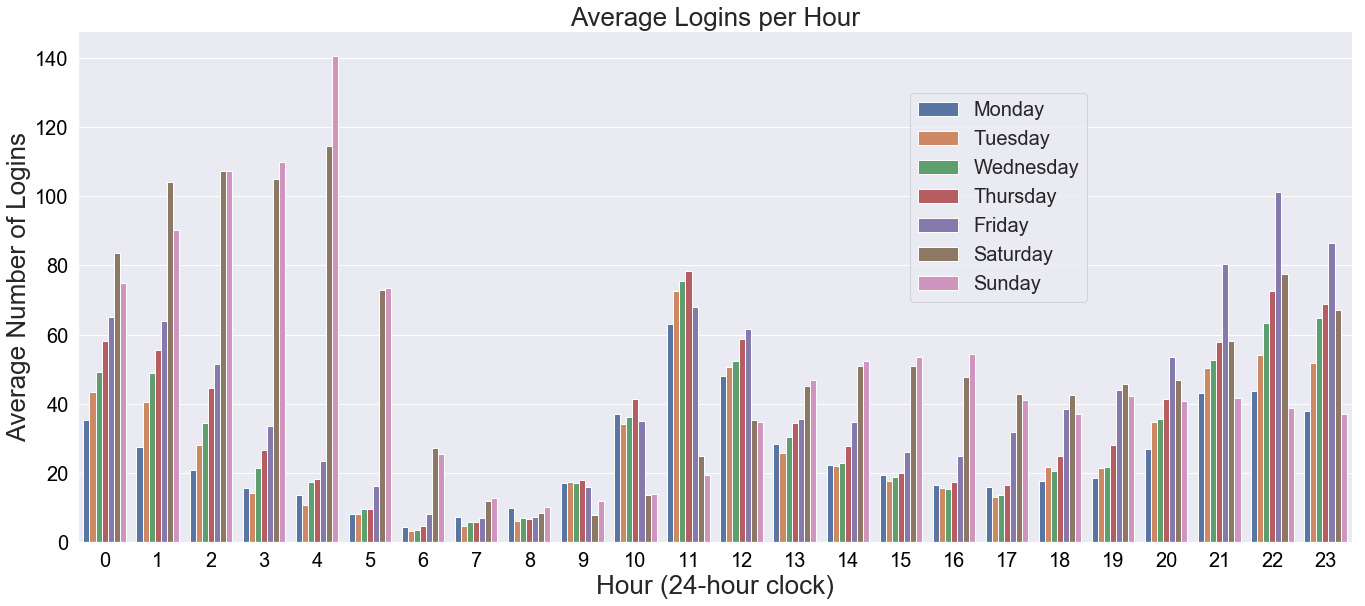

In [125]:
# plot average hourly use
sns.catplot(x='hour', y='avg_num_logins', data=avg_hourly_logins_df, kind = 'bar', 
            hue='day_of_week',height=8, aspect=11.7/5, legend=False)
ax = plt.gca()
ax.set_title('Average Logins per Hour', fontsize = 26)
ax.set_xlabel('Hour (24-hour clock)', fontsize = 26)
ax.set_ylabel('Average Number of Logins', fontsize = 26)
ax.tick_params(labelsize=20,labelcolor="black")
ax.legend(bbox_to_anchor=(0.7,0.7,0.1, 0.2),fontsize=20)

# Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

### Assumption:
#### 1. There is an electronic record of the number of cars that use the bridge, as to reimburse the partner drivers, the city and drivers would need a record of crossing.
#### 2. There is historical data available on bridge use
#### The key metric I would use is change in weekday activity. Specifically, during the daytime hours on weekdays, is there an increase of cars entering the bridge from Gotham and during the night is there an increase of cars entering the bridge from Metropolis. I choose this metric because it required only two assumptions, is easily measured, and this metric does not require waiting for reimbursement data to accumulate.

#### In order to answer the above questions I would use two hypothesis tests.

#### H0: There is no difference between the mean number of cars entering the bridge from Gotham during the daytime hour in weekdays, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.

#### H2: There is an INCREASE in the mean number of cars entering the bridge from Gotham during the daytime hour in weekdays, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.

#### H0: There is no difference between the mean number of cars entering the bridge from Metropolis during the night time in weekdays, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.

#### H2: There is an INCREASE in the mean number of cars entering the bridge from Metropolis during the night time in weekdays, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.

#### I would use a upper-tailed Z-test to determine the p-value of each hypothesis.

#### If the p-value is less than 0.05 for BOTH tests I would reject the null hypotheses and recommend the reimbursement program continue, and the study should be repeated in a year with more data.

#### If the p-value is greater than 0.05 for BOTH tests I would fail to reject the null hypotheses and recommend that a different program be developed to increase partner driving between the two cities.

#### If the p-value is mixed, so only one hypothesis has a p-value less than 0.05 I would recommend that the analysis is inconclusive and that further investigation is needed.

# Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).
#### Data description
#### ● city: city this user signed up in
#### ● phone: primary device for this user
#### ● signup_date: date of account registration; in the form ‘YYYYMMDD’
#### ● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
#### ● avg_dist: the average distance in miles per trip taken in the first 30 days after signup
#### ● avg_rating_by_driver: the rider’s average rating over all of their trips
#### ● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
#### ● surge_pct: the percent of trips taken with surge multiplier > 1
#### ● avg_surge: The average surge multiplier over all of this user’s trips
#### ● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
#### ● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
#### ● weekday_pct: the percent of the user’s trips occurring during a weekday

In [204]:
with open('ultimate_data_challenge.json') as data_file:
    data_log = json.load(data_file)

In [205]:
data=pd.DataFrame.from_dict(data_log)

In [206]:
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [207]:
print(data.dtypes)

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
ultimate_black_user          bool
weekday_pct               float64
dtype: object


In [208]:
# chnage the data type of column signup_date and last_trip_date to datetime
data['last_trip_date'] = pd.to_datetime(data['last_trip_date']) 
data['signup_date'] = pd.to_datetime(data['signup_date']) 

In [209]:
# check if the customer is still active
last_record = data['last_trip_date'].max()
buffer = last_record - pd.Timedelta('30 days')
data['active'] = (data.last_trip_date > buffer).astype('int')

In [210]:
active = data[data.active==1]
inactive = data[data.active==0]

In [211]:
# Calculate the percentage of active users
retained = len(active)/(len(data))
print(round(retained*100,2),'% of users are retained')

36.62 % of users are retained


In [212]:
# calculate the mean and standard deviation for each feature
print('active user average travelled distance is',round(active.avg_dist.mean(),2))
print('inactive user average travelled distance is',round(inactive.avg_dist.mean(),2))


active user average travelled distance is 5.12
inactive user average travelled distance is 6.19


In [213]:
print('active user average rating by driver is',round(active.avg_rating_by_driver.mean(),2))
print('inactive user average rating by driver is',round(inactive.avg_rating_by_driver.mean(),2))

active user average rating by driver is 4.76
inactive user average rating by driver is 4.79


In [214]:
print('active user average  surge is',round(active.avg_surge.mean(),2))
print('inactive user average  surge is',round(inactive.avg_surge.mean(),2))

active user average  surge is 1.07
inactive user average  surge is 1.08


In [215]:
print('active user average  surge percent is',round(active.surge_pct.mean(),2))
print('inactive user average  surge percent is',round(inactive.surge_pct.mean(),2))

active user average  surge percent is 9.13
inactive user average  surge percent is 8.69


In [216]:
print('active user averageul timate_black_user is',round(active.ultimate_black_user.mean(),2))
print('inactive user average ultimate_black_user is',round(inactive.ultimate_black_user.mean(),2))

active user averageul timate_black_user is 0.51
inactive user average ultimate_black_user is 0.3


In [226]:
print('active user average weekday_pct is',round(active.weekday_pct.mean(),2))
print('inactive user average weekday_pct is',round(inactive.weekday_pct.mean(),2))

active user average weekday_pct is 62.21
inactive user average weekday_pct is 60.18


In [ ]:
active['iphone']=(active.phone=='iPhone')
active['android']=(active.phone=='Android')

In [ ]:
inactive['iphone']=(inactive.phone=='iPhone')
inactive['android']=(inactive.phone=='Android')

In [233]:
print('active user average iphone user is is',round(active.iphone.mean(),2))
print('active user average android user is',round(active.android.mean(),2))

active user average iphone user is is 0.83
active user average android user is 0.16


In [234]:
print('inactive user average iphone user is is',round(inactive.iphone.mean(),2))
print('inactive user average android user is',round(inactive.android.mean(),2))

inactive user average iphone user is is 0.61
inactive user average android user is 0.38


In [ ]:
active['Winterfell']=(active.city=='Winterfell')
active['Kings_Landing']=(active.city=="King's Landing")
active['Astapor']=(active.city=='Astapor')
inactive['Winterfell']=(inactive.city=='Winterfell')
inactive['Kings_Landing']=(inactive.city=="King's Landing")
inactive['Astapor']=(inactive.city=='Astapor')

In [253]:
print('active user average Winterfell is',round(active.Winterfell.mean(),2))
print("active user average King's Landing user is",round(active.Kings_Landing.mean(),2))
print('active user average Astapor is',round(active.Astapor.mean(),2))
print('---------------------------------------')
print('inactive user average Winterfell is',round(inactive.Winterfell.mean(),2))
print("inactive user average King's Landing user is",round(inactive.Kings_Landing.mean(),2))
print('inactive user average Astapor is',round(inactive.Astapor.mean(),2))


active user average Winterfell is 0.44
active user average King's Landing user is 0.34
active user average Astapor is 0.22
---------------------------------------
inactive user average Winterfell is 0.48
inactive user average King's Landing user is 0.12
inactive user average Astapor is 0.39


#### The numbers above does not show the dignificant difference in features' value between active and inactive users.

##### Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

In [254]:
data['iphone']=(data.phone=='iPhone')
data['android']=(data.phone=='Android')
data['Winterfell']=(data.city=='Winterfell')
data['Kings_Landing']=(data.city=="King's Landing")
data['Astapor']=(data.city=='Astapor')

In [259]:
data.iphone=data.iphone.astype('int')
data.android=data.android.astype('int')
data.Winterfell=data.Winterfell.astype('int')
data.Kings_Landing=data.Kings_Landing.astype('int')
data.ultimate_black_user=data.ultimate_black_user.astype('int')

In [260]:
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active,iphone,android,Winterfell,Kings_Landing,Astapor
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,1,46.2,1,1,0,0,1,0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,0,50.0,0,0,1,0,0,1
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,0,100.0,0,1,0,0,0,1
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,1,80.0,1,1,0,0,1,0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,0,82.4,0,0,1,1,0,0


This is a binary classification problem with both numerical and categorical data with 50000 data points. XGBoost is appropriate for the data, fast, and memory efficient. Other models that would be appropriate for this data would be random forests and logistic regression. One of the drawbacks of using a tree-based model is interpretation is not as straightforward as it is with linear models.

# Optimization of XGBoost Classifer Model
#### split data into training and test sets
#### optimize hyperparameters using the training set and random crossfold validation
#### validate using an unoptimized model AND the test set
#### train optimized model using the entire feature set

In [261]:
data.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'city', 'last_trip_date', 'phone', 'signup_date', 'surge_pct',
       'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct',
       'active', 'iphone', 'android', 'Winterfell', 'Kings_Landing',
       'Astapor'],
      dtype='object')

In [268]:
# install the xgboost before import the xgboost
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, cv, plot_importance
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [269]:
# define features and target
feature_columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
                   'surge_pct','trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct','iphone', 
                   'android', 'Winterfell', 'Kings_Landing', 'Astapor']
X = data[feature_columns]
y = data.active
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=123)

# Hyperparameter optimization

In [270]:
# dictionary of parameters to optimize, and the range of optimization values
parameters = {
    'max_delta_step':[0,0.05],
    'scale_pos_weight':[0.95, 0.9],
    'subsample':[1,0.8],
    'learning_rate': [0.25, 0.2, 0.1],
    'min_child_weight':[0,1,2],
    'gamma':[1, 2, 3]
    }

In [271]:
# instantiate classifier
xg_clf = XGBClassifier(objective = 'binary:logistic', random_state = 42, 
                       silent = 1, n_estimators=10, max_depth= 8)

# RandomSearch
grid_search = GridSearchCV(param_grid= parameters, estimator = xg_clf, cv=3, scoring='accuracy')
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=1, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_delta_step': [0, 0.05], 'scale_pos_weight': [0.95, 0.9], 'subsample': [1, 0.8], 'learning_rate': [0.25, 0.2, 0.1], 'min_child_weight': [0, 1, 2], 'gamma': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [272]:
# Print best parameters and results
print(grid_search.best_params_)
print(grid_search.best_score_)

{'gamma': 3, 'learning_rate': 0.25, 'max_delta_step': 0, 'min_child_weight': 0, 'scale_pos_weight': 0.95, 'subsample': 1}
0.7873714285714286


In [273]:
# optimized parameters
optimized_parameters = {'objective':'binary:logistic',
                        'n_estimators': 10,
                        'random_state': 42,
                        'silent': 0,
                        'subsample': 1, 
                        'scale_pos_weight': 0.95, 
                        'min_child_weight': 1, 
                        'max_depth': 8, 
                        'max_delta_step': 0, 
                        'learning_rate': 0.2, 
                        'gamma': 3
                       }

In [274]:
xg_clf_opt = XGBClassifier(**optimized_parameters)
xg_clf_opt.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=3, learning_rate=0.2, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.95,
       seed=None, silent=0, subsample=1)

In [283]:
# predict the labels
y_opt_pred = xg_clf_opt.predict(X_train)
# score model
score = accuracy_score(y_train, y_opt_pred)
# print accuracy
print("The resulting accuracy of the optimized classifier is {}.".format(round(score,4)))

The resulting accuracy of the optimized classifier is 0.8086.


In [284]:
# train unoptimized model
xg_clf.fit(X_train, y_train)
# predict the labels of unoptimized model
y_unopt_pred = xg_clf.predict(X_train)
# score model
un_score = accuracy_score(y_train, y_unopt_pred)
# print accuracy
print("The resulting accuracy of the unoptimized classifier is {}.".format(round(un_score,4)))

The resulting accuracy of the unoptimized classifier is 0.8002.


In [285]:
# predict the labels
y_opt_test = xg_clf_opt.predict(X_test)
# score model
test_score = accuracy_score(y_test, y_opt_test)
# print accuracy
print("The resulting accuracy of the optimized classifier for the test set is {}.".format(round(test_score,4)))

The resulting accuracy of the optimized classifier for the test set is 0.7901.


The accuracy of optimized classifier for the test set is lower than that of unoptimized classifier, therefore, it is overfitting, so we should proceed with the default parameters.

In [286]:
# predict the labels of unoptimized model using the test set
y_unopt_test = xg_clf.predict(X_test)
# score model
test_score = accuracy_score(y_test, y_unopt_test)
# print accuracy
print("The resulting accuracy of the unoptimized classifier is {}.".format(round(test_score,4)))

The resulting accuracy of the unoptimized classifier is 0.7862.


In [287]:
# instantiate classifier
xg_clf_final = XGBClassifier(objective = 'binary:logistic', random_state = 42, silent = 1, n_estimators=200, max_depth= 8)
# train final model
xg_clf_final.fit(X, y)

y_final_pred = xg_clf_final.predict(X_test)
# score model
score = accuracy_score(y_test, y_final_pred)
# print accuracy
print("The resulting accuracy of the unoptimized classifier is {}.".format(round(score,4)))
# save model
pickle.dump(xg_clf_final, open('final_model.pickle', 'wb'))

The resulting accuracy of the unoptimized classifier is 0.8597.


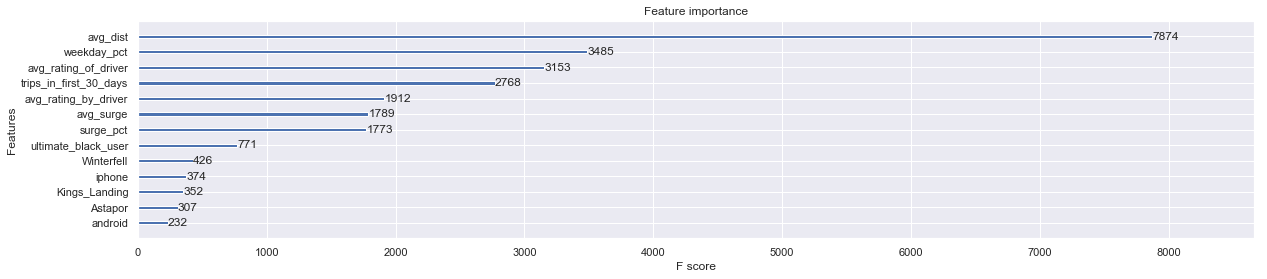

In [280]:
plot_importance(xg_clf_final)

# Conclusion
### The default parameters produced the best performing XGBoost model, resulting in a classification accuracy of 85.97% for the test data. The factors that most heavily influence rider retention are the average distance in miles per trip taken in the first 30 days after signup AND the percent of the user's trips occuring during a weekday.